In [ ]:
import pprint
import os
from rdflib import Namespace
from cmmn3 import parseModel, convertModel, convertLog, reasonAll, showCase, showErrors

n3Path = "cmmn3/n3/"
xmlNs = {"cmmn": "http://www.omg.org/spec/CMMN/20151109/MODEL"}
modelNs = Namespace("http://ontario.org/qbp/cap#")

xmlPath = "/Users/wvw/Dropbox/research/projects/Montfort PM/cmmn/cap-all.cmmn"
modelPath = "ttl/cap/model.ttl"
csvPath = "/Users/wvw/git/pm/mft/data/subsets/cap_labreq_map.csv"
obsPath = "ttl/cap/obs/obs_all.ttl"
imgPath = "js/diagram.png"

## Convert TTL

### Model

In [ ]:
itemObjs = parseModel(xmlPath, xmlNs)
# pprint.pprint(itemObjs)
convertModel(itemObjs, modelNs, modelPath)

### Log

In [47]:
convertLog(csvPath, modelNs, destPath=obsPath)

## Check compliance

### Reason

In [5]:
errors, finals = reasonAll(modelPath, obsPath, n3Path, printerr=False)
print("errors:", errors.columns)
print("finals:", finals.columns)

count: 0
count: 10
count: 20
count: 30
count: 40
count: 50
count: 60
count: 70
count: 80
count: 90
count: 100
errors: Index(['case', 'item', 'error', 'type'], dtype='object')
finals: Index(['case', 'item', 'type'], dtype='object')


In [ ]:
# aggregate errors

num_cases = len(finals['case'].unique())
num_item = errors.groupby('item').apply(lambda g: len(g)).apply(lambda num: num if num <= num_cases else num_cases)
print(num_item)
num_item_errors =  errors.groupby([ 'item', 'error' ]).apply(lambda g: len(g)).apply(lambda num: num if num <= num_cases else num_cases)
print(num_item_errors)

item
Blood cultures                                          100
antibiotics                                             100
oxygen saturation                                       100
routine bloodwork: CBC, electrolytes, renal function    100
urine antigen testing                                   100
x-ray                                                     1
dtype: int64
item                                                  error                         
Blood cultures                                        mandatoryNotDone                  100
antibiotics                                           mandatoryNotDone                  100
oxygen saturation                                     mandatoryNotDone                  100
routine bloodwork: CBC, electrolytes, renal function  inactiveToCompleted                36
                                                      mandatoryNotDone                   64
                                                      nonRepetitiveMultipleCo

### Show

In [ ]:
itemObjs = parseModel(xmlPath, xmlNs)

In [ ]:
showCase((errors, finals), '100057', itemObjs, xmlPath, imgPath)

In [ ]:
showErrors(errors, itemObjs, xmlPath, imgPath)

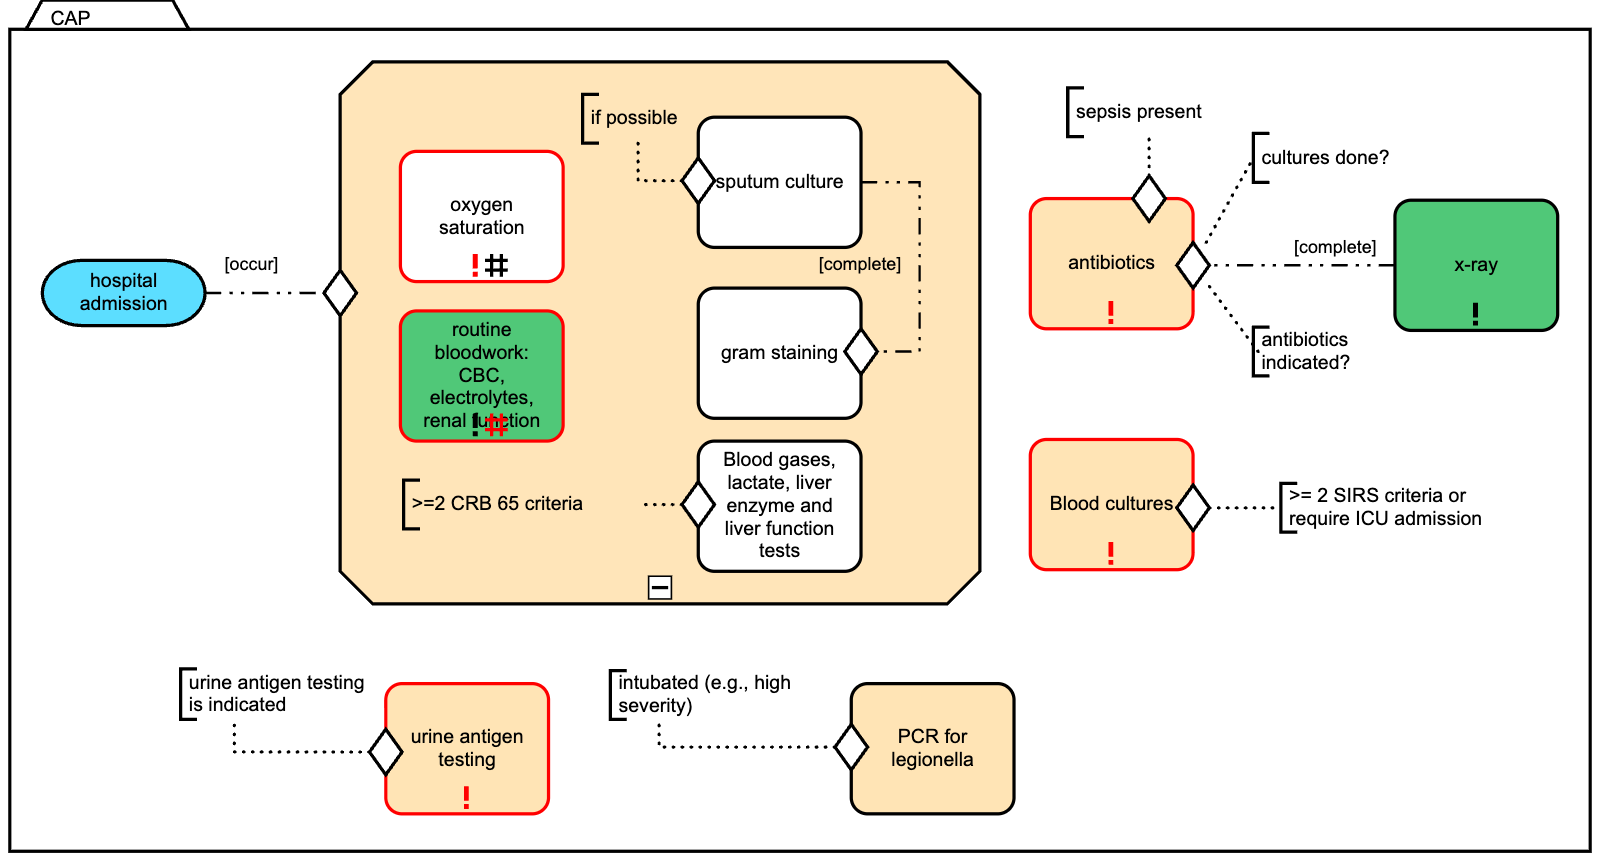

In [ ]:
from IPython.display import Image, display


display(Image(filename=imgPath))